# TP3 Big Data

#### Parte 1  - Creación de variables, histogramas, kernels y resumen de la base de datos final

En el codigo de abajo es como obtuvimos la Base-Final con la cual vamos a trabajar.

In [1]:
import pandas as pd
from mappings import STRING_MAPPINGS

df_2024 = pd.read_excel("usu_individual_T124.xlsx")
df_2004 = pd.read_stata("usu_individual_T104.dta")

df_2004.columns = df_2004.columns.str.upper()
df_2024.columns = df_2024.columns.str.upper()

df_2024['REGION'] = df_2024['REGION'].astype(str)
df_2004['REGION'] = df_2004['REGION'].astype(str)

def apply_mappings(df, col, mapping):
    """Aplica los mapeos a una columna específica."""
    if col == 'CH14':
        if df.equals(df_2004):
            return df[col].replace(mapping)
        else:
            return df[col].apply(
                lambda x: mapping.get(str(int(x)).zfill(2)) 
                if pd.notnull(x) and isinstance(x, (int, float)) and float(x).is_integer() 
                else mapping.get(str(x).strip(), x)
            )
    else:
        return df[col].astype(str).str.strip().map(mapping).fillna(df[col])

for col, mapping in STRING_MAPPINGS.items():
    df_2004[col] = apply_mappings(df_2004, col, mapping)
    df_2024[col] = apply_mappings(df_2024, col, mapping)

df_2004 = df_2004[df_2004['REGION'] == "Pampeana"].copy()
df_2024 = df_2024[df_2024['REGION'] == "Pampeana"].copy()

df_combined = pd.concat([df_2004, df_2024], 
                       ignore_index=True, 
                       join='outer')

df_combined.to_excel("Base_Final.xlsx", index=False)

C:\Users\Mi compu\AppData\Local\Temp\ipykernel_6052\1856469427.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[col].astype(str).str.strip().map(mapping).fillna(df[col])
C:\Users\Mi compu\AppData\Local\Temp\ipykernel_6052\1856469427.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[col].astype(str).str.strip().map(mapping).fillna(df[col])
C:\Users\Mi compu\AppData\Local\Temp\ipykernel_6052\1856469427.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future versio

##### Ejercicio 1

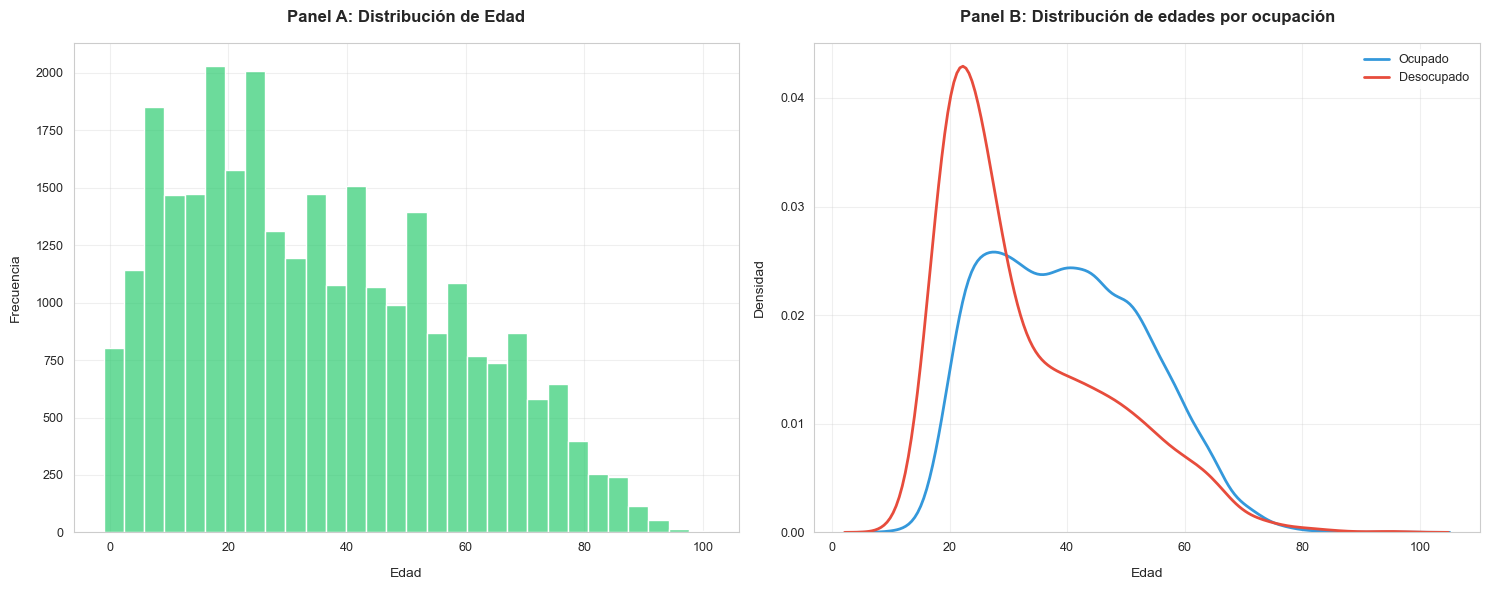

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['grid.alpha'] = 0.3

df = pd.read_excel('Base_Final.xlsx')

df['CH06'] = pd.to_numeric(df['CH06'], errors='coerce')
df['edad2'] = df['CH06'] ** 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=df, x='CH06', bins=30, ax=ax1, color='#2ecc71', alpha=0.7)
ax1.set_title('Panel A: Distribución de Edad', fontsize=12, pad=15, fontweight='bold')
ax1.set_xlabel('Edad', fontsize=10, labelpad=10)
ax1.set_ylabel('Frecuencia', fontsize=10, labelpad=10)
ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.grid(True, alpha=0.3)


sns.kdeplot(data=df[df['ESTADO'] == 'Ocupado'], x='CH06', label='Ocupado', 
            color='#3498db', ax=ax2, linewidth=2)
sns.kdeplot(data=df[df['ESTADO'] == 'Desocupado'], x='CH06', label='Desocupado', 
            color='#e74c3c', ax=ax2, linewidth=2)
ax2.set_title('Panel B: Distribución de edades por ocupación', fontsize=12, pad=15, fontweight='bold')
ax2.set_xlabel('Edad', fontsize=10, labelpad=10)
ax2.set_ylabel('Densidad', fontsize=10, labelpad=10)
ax2.tick_params(axis='both', which='major', labelsize=9)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9, frameon=True, facecolor='white', edgecolor='none')

plt.tight_layout()
plt.show()

Panel A muestra una gran concentración de personas jóvenes (hasta 30 años), lo que probablemente se debe a que estás trabajando con un dataset donde la mayoría son jóvenes.

Panel B muestra que los desocupados tienen una mayor dispersión en su distribución de edades, lo que indica que hay desocupados tanto en los rangos jóvenes como en edades mayores, mientras que los ocupados se concentran más en las edades jóvenes.

##### Ejercicio 2

In [3]:
df['CH12'] = df['CH12'].replace(['0', 'Ns./Nr.', '99', 'Jardín/preescolar', 'Jardín/Preescolar'], 'No tiene')
df['CH12'] = df['CH12'].replace(['EGB'], 'Primario')
df['CH12'] = df['CH12'].replace(['Educación especial (discapacitado)'], 'No tiene')

años_base = {
    'Primario': 6,
    'Secundario': 12,
    'Polimodal': 12,
    'Superior no universitario': 15,
    'Universitario': 17,
    'Terciario': 15,
}


def calcular_años_educacion(row):
    nivel = row['CH12']
    finalizo = row['CH13']
    año_aprobado = row['CH14']
    
    if pd.isna(nivel) or nivel == 'No tiene':
        return 0
    
    if finalizo == 'Sí':
        return años_base.get(nivel, 0)
    else:
        base = 0
        if nivel in ['Secundario', 'Polimodal']:
            base = 6
        elif nivel in ['Terciario', 'Superior no universitario', 'Universitario']:
            base = 12

        try:
            return base + int(año_aprobado)
        except:
            return base

df['educ'] = df.apply(calcular_años_educacion, axis=1)

descripcion = df['educ'].describe()

print("Estadísticas descriptivas de años de educación:\n")
print(f"Promedio: {descripcion['mean']:.2f} años")
print(f"Desviación estándar: {descripcion['std']:.2f}")
print(f"Mínimo: {descripcion['min']:.0f} años")
print(f"Mediana (p50): {descripcion['50%']:.0f} años")
print(f"Máximo: {descripcion['max']:.0f} años")

Estadísticas descriptivas de años de educación:

Promedio: 8.52 años
Desviación estándar: 5.04
Mínimo: 0 años
Mediana (p50): 8 años
Máximo: 21 años


A partir de esta construcción, se observó que el promedio de años de educación es de 8,27 años, con una desviación estándar de 4,87. El valor mínimo es 0 años, correspondiente a personas sin educación formal, mientras que el máximo es 21 años, lo que indicaría estudios de posgrado completos. La mediana es de 8 años, lo cual indica que al menos la mitad de los individuos en la muestra no completaron el nivel secundario.

##### Ejercicio 3

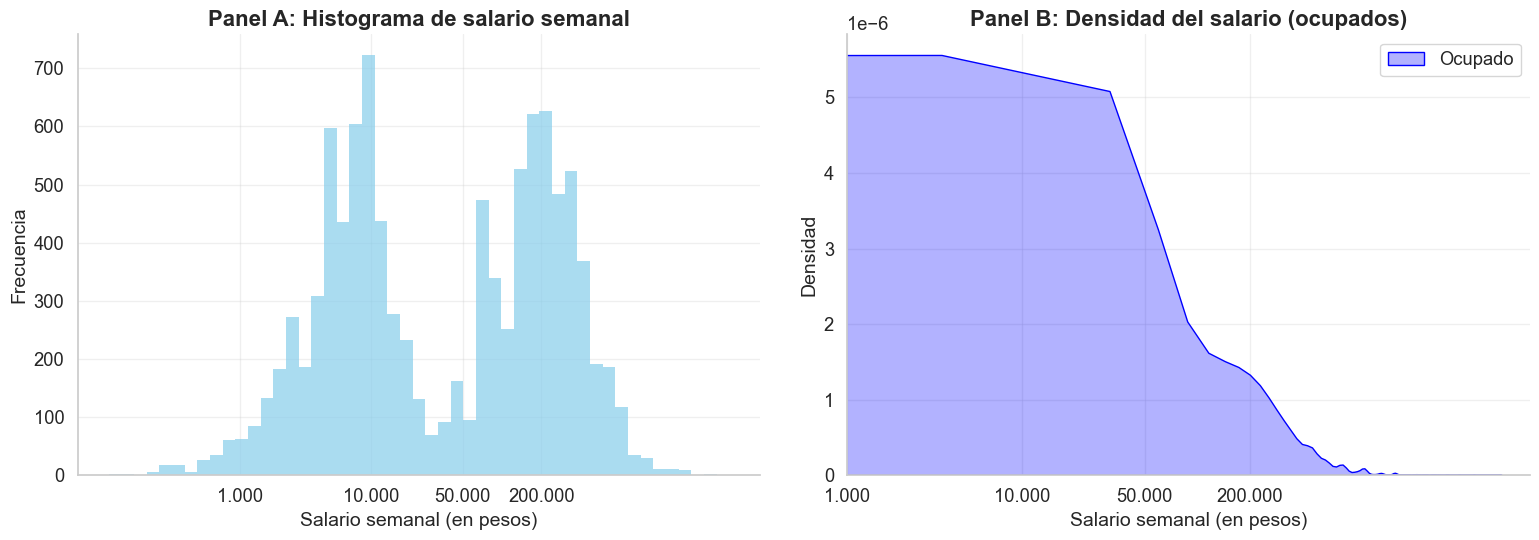

In [4]:
#Variable salario_semanal:
df = pd.read_excel("Base_Final.xlsx")

df.loc[df['ANO4'] == 2004, 'P21'] = df.loc[df['ANO4'] == 2004, 'P21'] * 18000

df['salario_semanal'] = df['P21'] / 40

# Graficos: 

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

ticks = [1000, 10000, 50000, 200000]
labels = [f"{t:,}".replace(",", ".") for t in ticks]

min_salario = df['salario_semanal'][df['salario_semanal'] > 0].min()
max_salario = df['salario_semanal'].max()
log_bins = np.logspace(np.log10(min_salario), np.log10(max_salario), 50)

plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
sns.histplot(
    data=df, 
    x="salario_semanal", 
    bins=log_bins, 
    color="skyblue", 
    edgecolor="black", 
    alpha=0.7
)
plt.xscale('log')
plt.xticks(ticks, labels)
plt.xlabel('Salario semanal (en pesos)')
plt.ylabel('Frecuencia')
plt.title("Panel A: Histograma de salario semanal", fontweight='bold')
sns.despine()

plt.subplot(1, 2, 2)
ocupado_data = df[(df['ESTADO'] == 'Ocupado') & (df['salario_semanal'] > 0)]

if not ocupado_data.empty:
    sns.kdeplot(data=ocupado_data, x='salario_semanal', label='Ocupado', color='blue', fill=True, alpha=0.3)

plt.xscale('log')
plt.xticks(ticks, labels)
plt.xlabel('Salario semanal (en pesos)')
plt.ylabel('Densidad')
plt.title('Panel B: Densidad del salario (ocupados)', fontweight='bold')
plt.legend()
sns.despine()

plt.tight_layout(pad=2)
plt.show()

En conjunto, los gráficos sugieren una estructura salarial desigual, con una parte significativa de la población concentrada en niveles bajos y medios de ingreso, y una minoría con salarios más elevados. La bimodalidad podría reflejar diferencias por tipo de ocupación, nivel de formalidad o calificación laboral.

##### Ejercicio 4

In [5]:
df['PP3E_TOT'] = pd.to_numeric(df['PP3E_TOT'], errors='coerce')
df['PP3F_TOT'] = pd.to_numeric(df['PP3F_TOT'], errors='coerce')

df['horastrab'] = df['PP3E_TOT'] + df['PP3F_TOT']

df_Htrabajo_limpio = df[(df['horastrab'] > 0) & (df['horastrab'] <= 168)]
descripcion_limpia = df_Htrabajo_limpio['horastrab'].describe()

print("Comparación de estadísticas descriptivas:\n")
print("Estadísticas con valores > 168 horas:")
print(f"Número de observaciones: {len(df[df['horastrab'] > 168])}")
print(f"Porcentaje de datos eliminados por > 168h: {(len(df[df['horastrab'] > 168]) / len(df[df['horastrab'] > 0]) * 100):.2f}%\n")

print("Estadísticas finales (0 < horas ≤ 168):")
print(f"Promedio: {descripcion_limpia['mean']:.2f} horas")
print(f"Desviación estándar: {descripcion_limpia['std']:.2f}")
print(f"Mínimo: {descripcion_limpia['min']:.0f} horas")
print(f"Mediana (p50): {descripcion_limpia['50%']:.0f} horas")
print(f"Máximo: {descripcion_limpia['max']:.0f} horas")
print(f"Número de observaciones: {len(df_Htrabajo_limpio)}")

Comparación de estadísticas descriptivas:

Estadísticas con valores > 168 horas:
Número de observaciones: 14
Porcentaje de datos eliminados por > 168h: 0.13%

Estadísticas finales (0 < horas ≤ 168):
Promedio: 39.60 horas
Desviación estándar: 18.46
Mínimo: 1 horas
Mediana (p50): 40 horas
Máximo: 126 horas
Número de observaciones: 10979


El análisis final, que excluye tanto los valores cero como aquellos superiores a 168 horas, nos proporcionó una distribución mucho más realista y confiable. Esta distribución muestra una clara concentración alrededor de las 40-45 horas semanales, lo cual es consistente con una jornada laboral estándar.

Decidimos eliminar valores superiores a 168, porq es matematicamente imposible trabajar esas horas, sabiendo que una semana tiene 168 horas.

##### Ejercicio 5

In [ ]:
df_2004 = df[df['ANO4'] == 2004]
df_2024 = df[df['ANO4'] == 2024]

cant_obs_2004 = len(df_2004)
cant_obs_2024 = len(df_2024)
cant_obs_total = len(df)

nas_estado_2004 = df_2004['ESTADO'].isna().sum()
nas_estado_2024 = df_2024['ESTADO'].isna().sum()
nas_estado_total = df['ESTADO'].isna().sum()

ocupados_2004 = (df_2004['ESTADO'] == 'Ocupado').sum()
ocupados_2024 = (df_2024['ESTADO'] == 'Ocupado').sum()
ocupados_total = (df['ESTADO'] == 'Ocupado').sum()

desocupados_2004 = (df_2004['ESTADO'] == 'Desocupado').sum()
desocupados_2024 = (df_2024['ESTADO'] == 'Desocupado').sum()
desocupados_total = (df['ESTADO'] == 'Desocupado').sum()

variables_limpias = ['var1', 'var2', 'var3', 'ESTADO', 'AÑO']
cant_variables_limpias = len(variables_limpias)

tabla_resumen = pd.DataFrame({
    '2004': [cant_obs_2004, nas_estado_2004, ocupados_2004, desocupados_2004],
    '2024': [cant_obs_2024, nas_estado_2024, ocupados_2024, desocupados_2024],
    'Total': [cant_obs_total, nas_estado_total, ocupados_total, desocupados_total]
}, index=[
    'Cantidad de observaciones',
    'Observaciones con NaN en ESTADO',
    'Cantidad de Ocupados',
    'Cantidad de Desocupados'
])

print(tabla_resumen)

print(f"\nCantidad de variables limpias y homogeneizadas: {cant_variables_limpias}")


                                  2004   2024  Total
Cantidad de observaciones        14821  14410  29231
Observaciones con NaN en ESTADO      0      0      0
Cantidad de Ocupados              5682   6302  11984
Cantidad de Desocupados           1035    453   1488

Cantidad de variables limpias y homogeneizadas: 5


#### PARTE 2, EJ 1

In [17]:
#Limpio los Nan y celdas vacías, asumimos que En edades aquellos que todavía no cumple 1 año concreto igualmente lo estan viviendo, apra asi reemplazar los "Menores de 1 año" por 1.
df['horastrab_']= df['horastrab'].fillna(0)
df["CH06_"] = pd.to_numeric(df['CH06'], errors='coerce')
df['edad'] = df["CH06_"].replace('Menos de 1 año', 0)
df["Edad"] = df['edad'].fillna(1)
df['educ'] = df.apply(calcular_años_educacion, axis=1)

In [18]:
df["Edad2"] = df["Edad"] **2 

In [19]:
Variab_m = pd.concat([
    df["Edad"],
    df["Edad2"],
    df['educ'],
    df['salario_semanal'],
    df['horastrab_']
], axis=1)
print(Variab_m)

       Edad   Edad2  educ  salario_semanal  horastrab_
0      52.0  2704.0     9        67500.000         9.0
1      40.0  1600.0     9        90000.000         0.0
2      19.0   361.0    12         3150.000         5.0
3      14.0   196.0     8            0.000         0.0
4       9.0    81.0     3            0.000         0.0
...     ...     ...   ...              ...         ...
29226  51.0  2601.0    12         9500.000        48.0
29227  27.0   729.0    16         6250.000        30.0
29228  23.0   529.0    15            0.000         0.0
29229  19.0   361.0    13            0.000         0.0
29230  18.0   324.0    10           -0.225        18.0

[29231 rows x 5 columns]


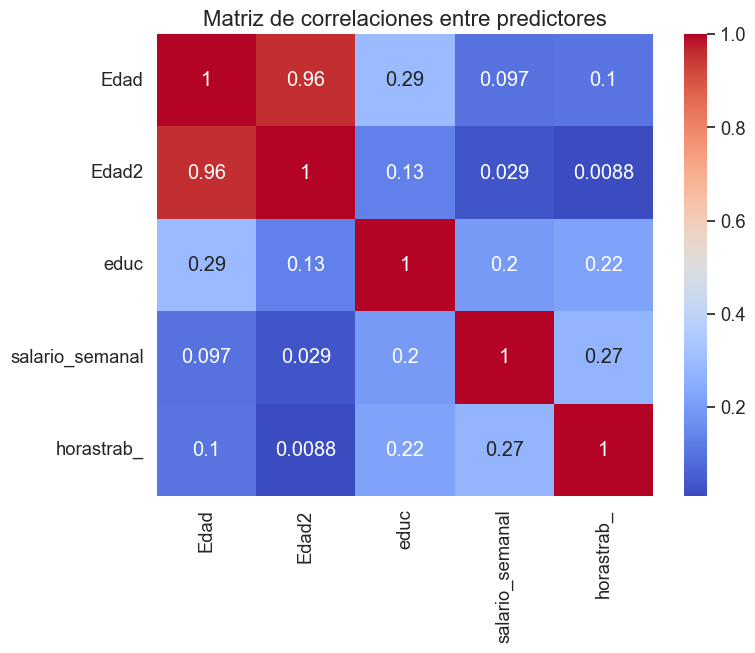

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(Variab_m.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlaciones entre predictores")
plt.show()


##### PARTE 2 A EJ 2

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [21]:
#Veo las columnas que estan en el df.
print(df.shape)
print("\n", df.info)
print("\n", df.dtypes)
print("\n", df.head())

(29231, 189)

 <bound method DataFrame.info of                               CODUSU  NRO_HOGAR COMPONENTE  H15  ANO4  \
0                           125051            1          1   Sí  2004   
1                           125051            1          2   Sí  2004   
2                           125051            1          3   Sí  2004   
3                           125051            1          4   Sí  2004   
4                           125051            1          5    0  2004   
...                              ...        ...        ...  ...   ...   
29226  TQRMNOQQYHLMKNCDEFKID00851884          1          2  Sí   2024   
29227  TQRMNOQQYHLMKNCDEFKID00851884          1          3  Sí   2024   
29228  TQRMNOQQYHLMKNCDEFKID00851884          1          4  Sí   2024   
29229  TQRMNOQQYHLMKNCDEFKID00851884          1          5  Sí   2024   
29230  TQRMNOQQYHLMKNCDEFKID00851884          1          6  Sí   2024   

            TRIMESTRE    REGION  \
0      1er. Trimestre  Pampeana   
1     

In [22]:
Variab_m = pd.concat([
    df["Edad"],
    df["Edad2"],
    df['educ'],
    df['salario_semanal'],
    df['horastrab_']
], axis=1)
print(Variab_m)

       Edad   Edad2  educ  salario_semanal  horastrab_
0      52.0  2704.0     9        67500.000         9.0
1      40.0  1600.0     9        90000.000         0.0
2      19.0   361.0    12         3150.000         5.0
3      14.0   196.0     8            0.000         0.0
4       9.0    81.0     3            0.000         0.0
...     ...     ...   ...              ...         ...
29226  51.0  2601.0    12         9500.000        48.0
29227  27.0   729.0    16         6250.000        30.0
29228  23.0   529.0    15            0.000         0.0
29229  19.0   361.0    13            0.000         0.0
29230  18.0   324.0    10           -0.225        18.0

[29231 rows x 5 columns]


In [25]:

#Caluclos previos para calcular el PCA
print(Variab_m.mean())

scaler = StandardScaler(with_std=True, with_mean=True)
Variab_m_transformed = pd.DataFrame(scaler.fit_transform(Variab_m), columns=Variab_m.columns)

print("Promedio luego de la transformación\n",Variab_m_transformed.mean())
print("Desvío estandár luego de la transformación\n",Variab_m_transformed.std())

print(Variab_m_transformed.head())

#Calcular PCA
pca = PCA()
Variab_m_pca = pca.fit_transform(Variab_m_transformed)

scores = Variab_m_pca
print(scores)

loading_vectors = pca.components_
print("Loadings:\n", pca.components_)
print("Loadings del CP1:\n",pca.components_[0]) 
pca.components_[0,0]



Edad                  34.780096
Edad2               1711.969450
educ                   8.500667
salario_semanal    48038.053204
horastrab_            15.386986
dtype: float64
Promedio luego de la transformación
 Edad               1.127884e-16
Edad2             -7.778512e-18
educ               1.672380e-16
salario_semanal   -5.444958e-17
horastrab_        -2.673863e-17
dtype: float64
Desvío estandár luego de la transformación
 Edad               1.000017
Edad2              1.000017
educ               1.000017
salario_semanal    1.000017
horastrab_         1.000017
dtype: float64
       Edad     Edad2      educ  salario_semanal  horastrab_
0  0.768321  0.537268  0.098587         0.129094   -0.195816
1  0.232903 -0.060641  0.098587         0.278340   -0.471742
2 -0.704080 -0.731664  0.690898        -0.297749   -0.318450
3 -0.927171 -0.821025 -0.098850        -0.318644   -0.471742
4 -1.150262 -0.883307 -1.086036        -0.318644   -0.471742
[[ 0.86831493 -0.3297846  -0.08748838 -0.2065832

0.6656651351940595

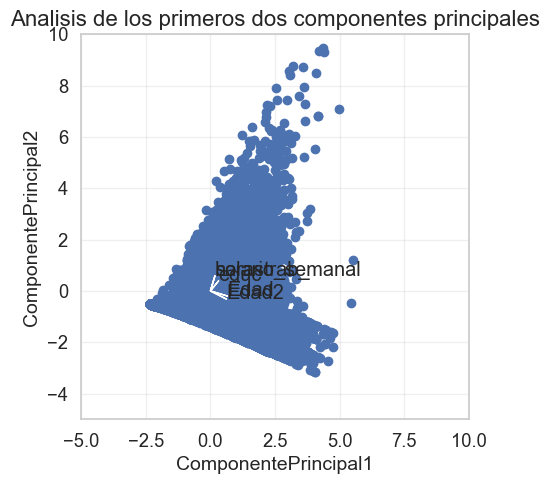

In [ ]:
#Ejercicio 3 Gráfico 
i, j = 0, 1 
fig, ax = plt.subplots(1, 1, figsize=(5, 5)) 
ax.scatter(scores[:,0], scores[:,1]) 
ax.set_xlabel('ComponentePrincipal%d' % (i+1))
ax.set_ylabel('ComponentePrincipal%d' % (j+1))

ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)

plt.title('Analisis de los primeros dos componentes principales')
for k in range(pca.components_.shape[1]): 
    ax.arrow(0, 0, pca.components_[i,k], pca.components_[j,k]) 
    ax.text(pca.components_[i,k], pca.components_[j,k], Variab_m.columns[k])


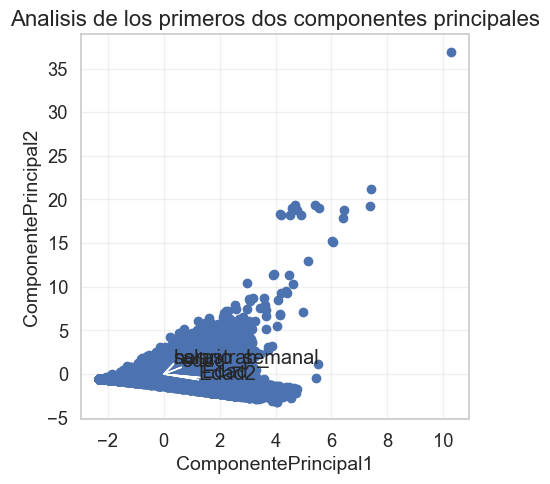

In [ ]:
i, j = 0, 1 

scale_arrow = s_ = 2 
scores[:,1] *= -1
pca.components_[1] *= -1 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(scores[:,0], scores[:,1]) 
ax.set_xlabel('ComponentePrincipal%d' % (i+1))
ax.set_ylabel('ComponentePrincipal%d' % (j+1))
plt.title('Analisis de los primeros dos componentes principales')
for k in range(pca.components_.shape[1]):
    ax.arrow(0, 0, s_*pca.components_[i,k], s_*pca.components_[j,k])
    ax.text(s_*pca.components_[i,k], s_*pca.components_[j,k], Variab_m.columns[k])

# Ejercicio 4 

[0.41980838 0.2737618  0.15719246 0.14464438 0.00459299]


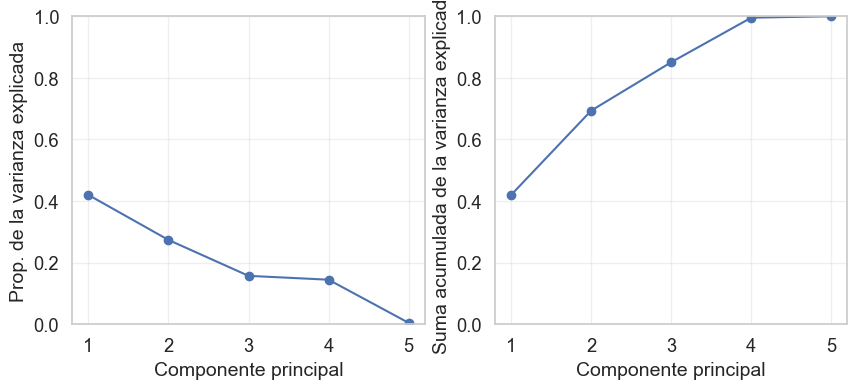

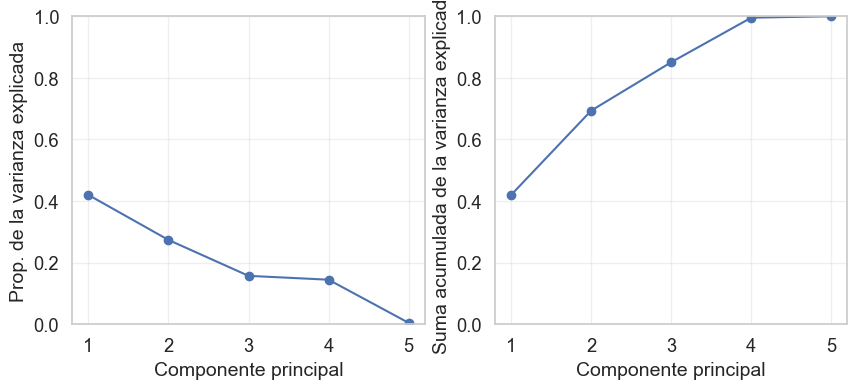

In [ ]:
print(pca.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(10, 4)) 
ticks = np.arange(pca.n_components_)+1 
ax = axes[0]
ax.plot(ticks, pca.explained_variance_ratio_ , marker='o')
ax.set_xlabel('Componente principal');
ax.set_ylabel('Prop. de la varianza explicada')
ax.set_ylim([0,1])
ax.set_xticks(ticks)

ax = axes[1]
ax.plot(ticks, pca.explained_variance_ratio_.cumsum(), marker='o') 
ax.set_xlabel('Componente principal')
ax.set_ylabel('Suma acumulada de la varianza explicada')
ax.set_ylim([0, 1])
ax.set_xticks(ticks)
fig

## Ejercicio 5 - Inciso b

In [126]:
# Primero sacamos el salario promedio y la edad promedio, para poder entender los gráficos posteriormente.
salario_promedio = df['salario_semanal'].mean()
educ_promedio = df['educ'].mean()

print(f"Salario promedio: {salario_promedio:.2f}")
print(f"Educación promedio: {educ_promedio:.2f}")


Salario promedio: 48038.05
Educación promedio: 8.50


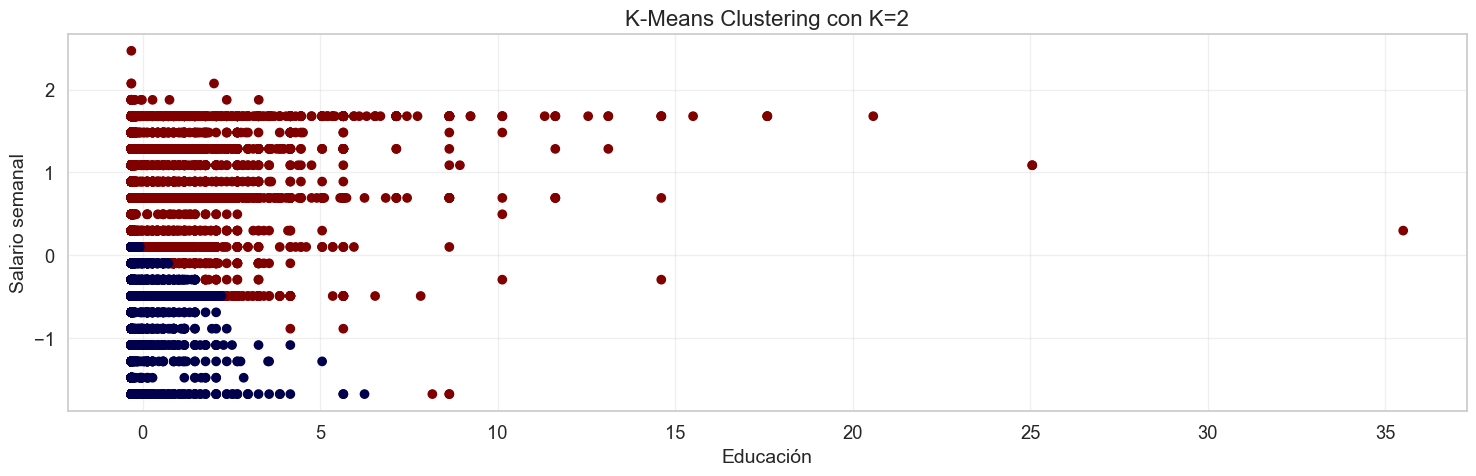

In [144]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

X = Variab_m_transformed[['salario_semanal','educ']].values # El .values nos convierte el dataFrame para ser interpretado como un array
kmeans2 = KMeans(n_clusters=2, random_state=10, init="random", n_init=20).fit(X)

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.scatter(X[:, 0], X[:, 1], c=kmeans2.labels_, cmap='seismic') #cmap de https://matplotlib.org/stable/users/explain/colors/colormaps.html
ax.set_title("K-Means Clustering con K=2")
ax.set_xlabel("Educación")
ax.set_ylabel("Salario semanal")
plt.tight_layout()
plt.show()


#### Entonces con un k = 2 se ve una clara división entre bajos ingresos y bajo salario semanal, con salario promedio o mayor con otros niveles de educación. Preferimos usar valores estandarizados para el salario a fin de que no se creen valores que generen distorsión en la interpretación, por lo que podemos entender que:
* si z = 0 -> salario promedio
* si z > 1 -> salario mayor al promedio
* si z < 1 -> salario menor al promedio

(Es decir, por ejemplo, z = 2 representa una persona que gana aproximadamente 2 desvíos estándar por encima del promedio.)

Veamos para k = 4 y k = 10

C:\Users\Mi compu\AppData\Local\Temp\ipykernel_6052\915251499.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


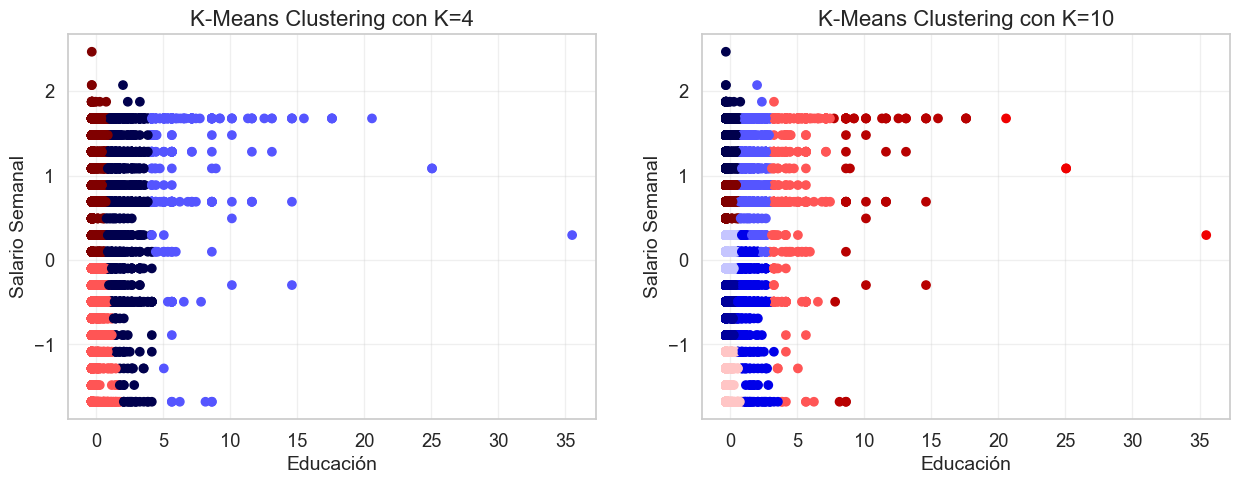

In [ ]:
kmeans4 = KMeans(n_clusters=4, random_state=10, init="random", n_init=20).fit(X)
kmeans10 = KMeans(n_clusters=10, random_state=10, init="random", n_init=20).fit(X)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
ax.scatter(X[:,0], X[:,1], c=kmeans4.labels_, cmap="seismic")
ax.set_xlabel("Educación")
ax.set_ylabel("Salario Semanal")
ax.set_title("K-Means Clustering con K=4")

ax = axes[1]
ax.scatter(X[:,0], X[:,1], c=kmeans10.labels_, cmap="seismic")
ax.set_xlabel("Educación")
ax.set_ylabel("Salario Semanal")
ax.set_title("K-Means Clustering con K=10")
fig.show()



Entonces para k = 4
* Subgrupo rosa: baja o nula educación y salario entre menor y promedio.
* Subgrupo rojo: baja o nula educación y salario entre mayor y promedio.
* Subgrupo azul oscuro: educación entre 0 y 5 años, grupo con salario entre promedio y mayor.
* Subgrupo celeste: grupo con salario entre promedio y mayor, el nivel de educación esta dispersado pero oscila entre 5 y 15 años en promedio.

Para k = 10 podemos hacer una interpretación similar, aunque la diferencia entre los distintos conjuntos se relativiza en diferencias sustanciales en el salario. Por lo tanto, con k = 4 es más facil dar una división entre perfiles "economico-educativos" respecto a la educación y el salario semanal.

## Ejercicio 5 - Inciso b

In [ ]:
# De vuelta, averiguamos el promedio de edad para entender el gráfico. Ya tenemos el de educación, averiguamos el del otro predictor:
edad_promedio = df['Edad'].mean()
print(f"Edad promedio: {edad_promedio:.2f}")

Edad promedio: 34.78


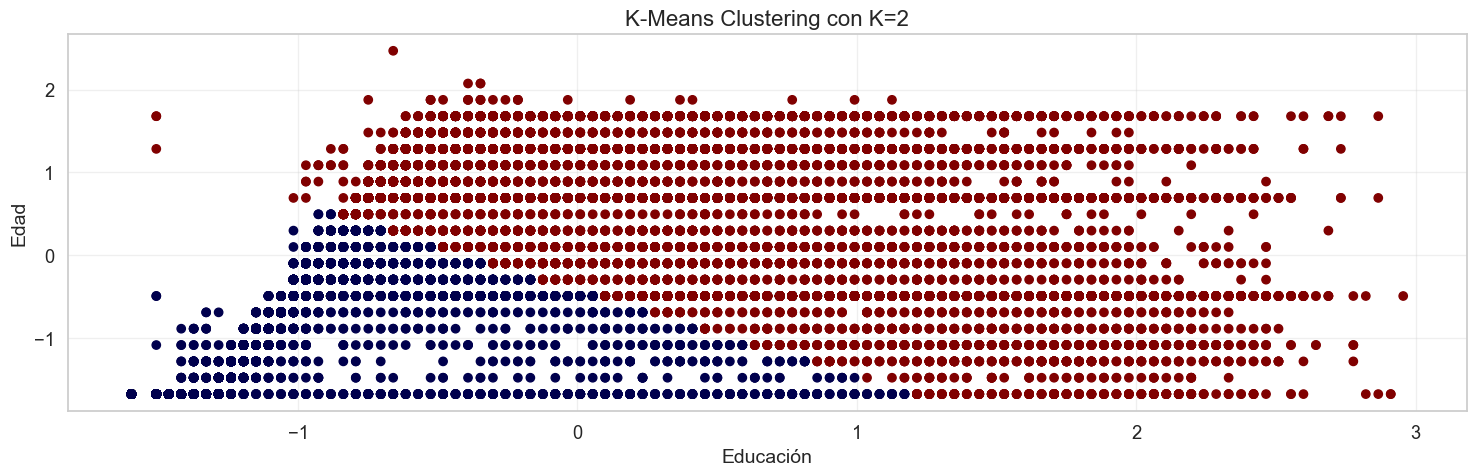

In [135]:
# Vemos el gráfico sin la variable ocupados/desocupados.
X = Variab_m_transformed[['Edad','educ']].values

fig, ax = plt.subplots(figsize=(15,5))
scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans2.labels_, cmap='seismic')
ax.set_title("K-Means Clustering con K=2")
ax.set_xlabel("Educación")
ax.set_ylabel("Edad")
plt.tight_layout()
plt.show()

C:\Users\Mi compu\AppData\Local\Temp\ipykernel_6052\1415217007.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


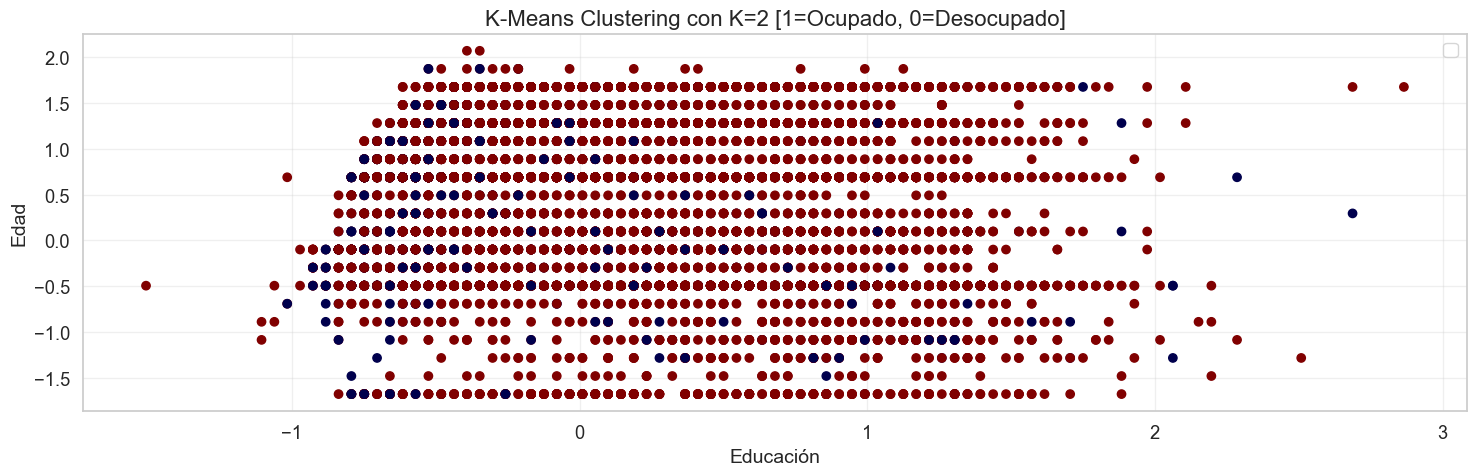

In [129]:
df['ocupado'] = df['ESTADO'].map({'Ocupado': 1, 'Desocupado': 0}) 
Variab_m_transformed['ocupado'] = df['ocupado'] # Retomamos esto para poder usar los subgrupos de ocupado y desocupado.

X = Variab_m_transformed[['Edad','educ']].values
ocupados = Variab_m_transformed['ocupado'].values

fig, ax = plt.subplots(figsize=(15,5))
scatter = ax.scatter(X[:, 0], X[:, 1], c=ocupados, cmap='seismic')
ax.set_title("K-Means Clustering con K=2 [1=Ocupado, 0=Desocupado]")
ax.set_xlabel("Educación")
ax.set_ylabel("Edad")
ax.legend()
plt.tight_layout()
plt.show()


Podemos ver en el gráfico que hay una gran concentración de puntos rojos (ocupados) y que los puntos azules (desocupados) se encuentran dispersos y sin una agrupación clara. O sea, no hay una relación clara entre la combinación de edad y educación respecto de la ocupación. Entonces el algoritmo K-means no logra separar adecuadamente a ocupados de desocupados, porque no existe una limitación que habilite la distinción entre ambos grupos (es decir, los predictores edad y educación no pueden definir correctamente que alguien este ocupado o no).


## Ejercicio 6

Voy a hacer una aclaración para este punto: se redujo el numero de muestras (100) porque de lo contrario no me corria en la compu.

C:\Users\Mi compu\AppData\Local\Temp\ipykernel_6052\3270374806.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


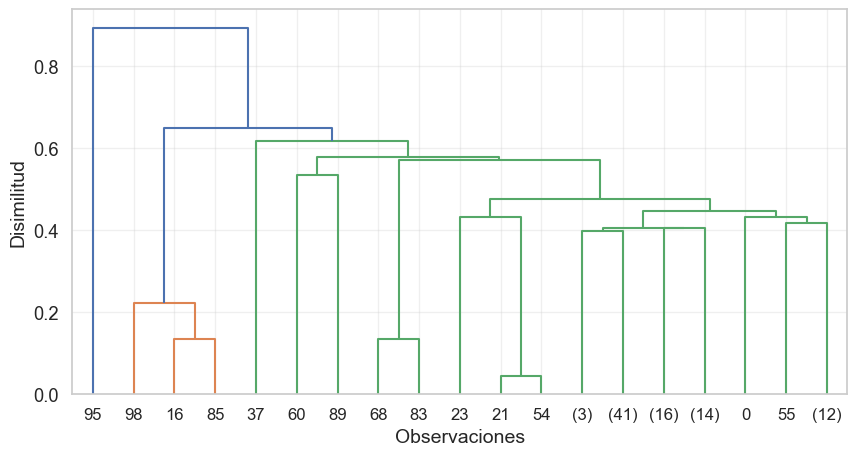

In [168]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris

subset = Variab_m_transformed[['Edad','educ']].sample(n=100, random_state=5) # 100 muestras, random_state define la posición de variables para que no sean aleatorias con cada código.
linkage_data = linkage(subset.values, metric='euclidean')

fig, ax = plt.subplots(figsize=(10,5))
dendrogram(linkage_data, truncate_mode="level", p=8)
ax.set_xlabel("Observaciones")
ax.set_ylabel("Disimilitud")
fig.show()

El dendrograma permite ver gráficamente los subgrupos para cada numero de clusters. En este caso, muestra como se agrupan las personas segun su edad y educación. No las grafica directamente si no qué tan parecidas son entre si. El eje X son las personas, y el eje Y muestra cuán distintas son cuando se las agrupa. Mientras más alto se juntan, más distintas son



In [172]:
print(subset) # Nos permite ver que se eligió del muestreo.


           Edad      educ
19     1.303740 -1.283473
23210  0.946794  0.690898
145   -1.284117 -1.678348
20793 -0.436370  1.085773
22240  1.036031  0.690898
...         ...       ...
859    0.500612 -1.678348
25546 -0.659462  1.085773
4875   0.322139 -0.493725
16223  2.597668 -0.493725
11609 -1.239498 -1.480911

[100 rows x 2 columns]
